# Non-linear Normalization for Sparse Data

###### Proposed Method:
- Clip the histogram values in a shorter range;
- Normalization between -1 and 1;
- $f(x) = sign(x) |x|^p$

###### Drawbacks:
- the method is not invertible;
- it seems to be suitable with real values, not with complex ones;

In [1]:
## Import Modules ##
import numpy as np
import matplotlib.pyplot as plt
from scipy import io, stats, special
import pickle

### Original Data

- Only Magnitudes
- Normalization wrt max

In [2]:
## Load Data ##
#path = 'C:/Users/enric/PycharmProjects/datasets/synth_frf_free_512x512x32.mat'
#data = io.loadmat(path)

## Original Data ##
#f = data['freq']
#x = data['x']
#y = data['y']
#frfs = data['frfs']

#image = np.abs(frfs[:,:,31])
#image = image/np.max(image)
#image = np.imag(frfs[:,:,31])

#plt.imshow(image, cmap='pink')
#plt.colorbar()
#plt.show()

#h, b = np.histogram(image, bins=100)
#plt.bar(np.arange(h.shape[0]), h)
#plt.xlim(-1,100)
#plt.show()

#print(image.min(), image.max())

In [3]:
path='../macerbi/Tesi/dataset/DatasetFiles/Dataset_xf/Dataset_xf_1'
data = pickle.load(open(path, 'rb'))

##### Functions

In [4]:
def piecewise_clip(image, mi, mx, p):

    #image_clip = np.zeros(image.shape) 
    image_clip=image
    
    # Non-linear clipping
    # i,j = np.where(image < mi)
    # image_clip[i, j] = 1e-4 * image[i, j] + (1 - 1e-4) * mi
    # i,j = np.where(image > mx)
    # image_clip[i, j] = 1e-4 * image[i, j] + (1 - 1e-4) * mx
    # i,j = np.where((image >= mi) & (image <= mx))
    # image_clip[i, j] = image[i, j]
    
    # MinMax Normalization
    #image_clip_norm = 2 * (image_clip - mi) / (mx - mi) - 1
    
    # Histogram scaling
    #image_clip_pow = np.power(np.abs(image_clip_norm), p)
    image_clip_pow = np.power(np.abs(image_clip), p)
    
    return image_clip_pow

def inv_piecewise_clip(image, mi, mx, p):
    
    image_inv_pow = np.zeros(image.shape)
    image_inv = np.zeros(image.shape)
    
    # Histogram backward scaling
    image_inv_pow = np.power(np.abs(image), 1/p)
    
    # MinMax inverse normalization
    #image_inv_norm = (image_inv_pow + 1) * (mx - mi) / 2 + mi
    #image_inv_norm = image_inv_pow
    
    # Inverse non-linear mapping
    #i,j = np.where(image_inv_norm < mi)
    #image_inv[i, j] = (image_inv_norm[i, j] - (1 - 1e-4) * mi) / 1e-4
    #i,j = np.where(image_inv_norm > mx)
    #image_inv[i, j] = (image_inv_norm[i, j] - (1 - 1e-4) * mx) / 1e-4
    #i,j = np.where((image_inv_norm >= mi) & (image_inv_norm <= mx))
    #image_inv[i, j] = image_inv_norm[i, j]
    image_inv = image_inv_pow
    
    return image_inv

def bc_clip(image, lam):
    bc_image = special.boxcox(image, lam)
    bc_min = bc_image.min()
    bc_max = bc_image.max()
    bc_image = (bc_image - bc_min) / (bc_max - bc_min)   
    return (bc_image, bc_min, bc_max)

def inv_bc_clip(image, lam, mi, mx):    
    bc_image = image * (mx - mi) + mi
    bc_image = special.inv_boxcox(bc_image, lam)
    return bc_image

##### Reconstruction error (w/o noise)

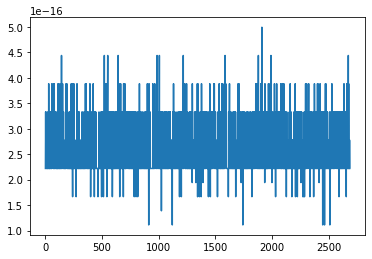

In [5]:
error = np.zeros((1,len(data)))

for idx,item in enumerate(data):
    image = np.abs(item[6])
    image = image / np.max(image)
    i1, mi, mx = bc_clip(image, 0.4)
    i2 = inv_bc_clip(i1, 0.4, mi, mx)
    error[0,idx] = np.max(np.abs(i2 - image))

x = np.arange(error.shape[1])
plt.plot(x, error[0,:])
plt.show()

In [6]:
error.max()

4.996003610813204e-16

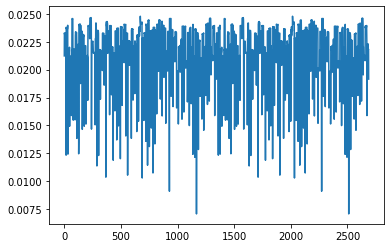

In [7]:
error = np.zeros((1,len(data)))
noise = np.random.uniform(0, .01, size=i1.shape)

for idx,item in enumerate(data):
    image = np.abs(item[6])
    image = image / np.max(image)
    i1, mi, mx = bc_clip(image, 0.4)
    # Add noise to simulate prediction error
    i1 = i1 - i1*noise
    i2 = inv_bc_clip(i1, 0.4, mi, mx)
    error[0,idx] = np.max(np.abs(i2 - image))

x = np.arange(error.shape[1])
plt.plot(x, error[0,:])
plt.show()

In [8]:
error.max()

0.024783799799373618

##### Qualitative example

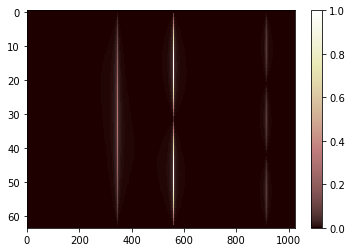

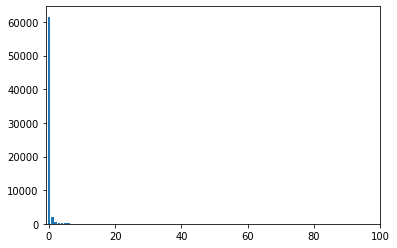

4.21905662403463e-24 1.0


In [9]:
## Original Data ##
frf = data[1000][6]

image = np.abs(frf)
image = image/np.max(image)

plt.imshow(image, cmap='pink', aspect='auto')
plt.colorbar()
plt.show()

h, b = np.histogram(image, bins=100)
plt.bar(np.arange(h.shape[0]), h)
plt.xlim(-1,100)
plt.show()

print(image.min(), image.max())

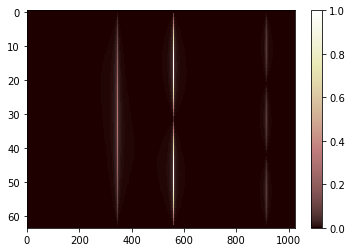

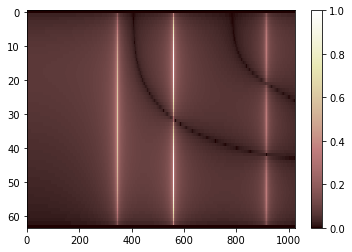

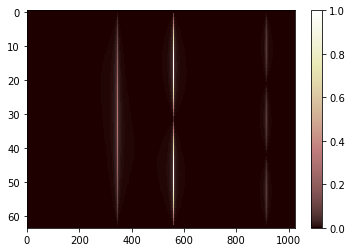

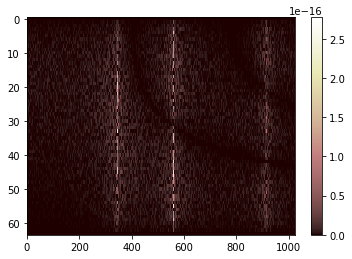

2.7755575615628914e-16


In [10]:
plt.imshow(image, cmap='pink', aspect='auto')
plt.colorbar()
plt.show()

i1, mi, mx = bc_clip(image, 0.4)
plt.imshow(i1, cmap='pink', aspect='auto')
plt.colorbar()
plt.show()

i2 = inv_bc_clip(i1, 0.4, mi, mx)
plt.imshow(i2, cmap='pink', aspect='auto')
plt.colorbar()
plt.show()

plt.imshow(np.abs(i2 - image), cmap='pink', aspect='auto')
plt.colorbar()
plt.show()

print(np.max(np.abs(i2-image)))

###### Forward and Backward Clipping - steps